In [1]:
#lancer la communication asynchrone avec thymio
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 36b6a277-86a1-4fde-a73f-2ed95257a43d

In [2]:
# Premade libraries
import cv2
import time
import math
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point, LineString

# Homemade functions
import Vision.vision as vs
import robot as rbt
import Global_Navigation.global_navigation as glb
import Motion_Control.thymio_control as ctrl

In [3]:
def get_angle2goal(geometry, goal):
    """

    Compute the angle between thecurent orientation of the tymio and its next goal
    :return: beta the angle btw goal/crt orientation
    """
    beta = math.atan2(goal[1] - geometry[0][1], goal[0] - geometry[0][0])
    if beta - geometry[1] < -np.pi:
        beta = -(beta - geometry[1] + np.pi)
    elif beta - geometry[1] > np.pi:
        beta = -(beta - geometry[1] - np.pi)
    else:
        beta = beta - geometry[1]
    return beta

def get_correct_orientation(beta, node, speed, tol):
    if abs(beta) < tol:
        #print("right angle")
        #ctrl.stop_motors(node)
        return(True)
    if beta < 0 :
        ctrl.set_motor_speed(-speed, speed, node)
        return(False)
    elif beta > 0:
        
        ctrl.set_motor_speed(speed, -speed, node)
        return(False)
    
def test_sensors(node,client, tolerance):
    sensor = ctrl.get_prox_sensors(node,client)
    for i in range(5):
        if sensor[i] > tolerance:
             return False 
    return True
    
def get_distance(pos, goal, tol, speed, node):
    dist = np.linalg.norm((goal[0]-pos[0], goal[1]-pos[1]))
    if dist < tol:
        ctrl.stop_motors(node)
        return True
    else:
        spLeft = speed
        spRight = speed
        for i in range(5):
            a = 4-i
            sensor = ctrl.get_prox_sensors(node,client)
            spLeft += sensor[i] * obstSpeedGain[i] // 100
            spRight += sensor[i] * obstSpeedGain[a]//100
        ctrl.set_motor_speed(spRight, spLeft, node)
        if(test_sensors(node, client, 3000)):
            ctrl.set_motor_speed(speed, speed, node)
            #aw(client.sleep(0.5))
        return False
    

        

In [9]:
cap = cv2.VideoCapture(0)
img = vs.get_image(cap)
margin = 40
obstSpeedGain = np.array([6,4,-2,-6,-8])
thymio = rbt.RobotNav()

100%|██████████| 3/3 [00:00<00:00, 75.34it/s]


fin state


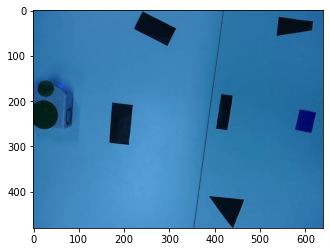

In [10]:
i = 0 #step vis graph
path = 0
while cap.isOpened():
    ret, frame = cap.read()
    
    if thymio.get_state() == 0:
        thymio.initialisation_step(frame, margin, False)
        thymio.set_state(1)
        path = thymio.get_path('real')
        print("fin state")
    
    if thymio.get_state() == 1:  #motion control commence
        pos_thy, two_centres, test_detect = vs.detect_start1(frame, False)  #recupere pos thymio, #test_detect bool a false si thymio pas detetc
        frame = glb.draw_path(frame, thymio.get_path('real')) #dessine chemin du thymio new fenetre
        path_img = thymio.get_path('img')
        if test_detect:
            frame = glb.draw_thymio(frame, path_img,"")   # dessine point thymio new fenetre
        #frame = glb.draw_thymio(frame, path_kalman)   # dessine point thymio new fenetre
        if test_detect:
            thymio.update_position_cam(two_centres, node, client)  #update pos thymio et angle dans la classe robot
        #else:
            #thymio.update_position_kalman(node, client, False)
    
        if len(path) > (i+1):
            next_goal = (path[i+1].x,path[i+1].y) 
            pos, teta = thymio.get_geometry()
            temp=ctrl.astolfi(pos, teta, next_goal, node, client) #astolfi controller
            if temp==1:
                i=i+1
        else : 
            ctrl.stop_motors(node)
            ctrl.leds_blink(node)
            break
    cv2.imshow('frame',frame)     
    if cv2.waitKey(1) == ord('q'):
        ctrl.stop_motors(node)
        break
        
cap.release()
cv2.destroyAllWindows()

In [6]:
cap.release()

[[[164.5 172.5  36.6]
  [230.5 224.5  18.2]]]
ok


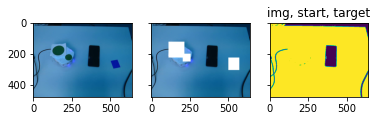

((197.0, 198.0), (535.0, 264.0), [[array([648.0805, 299.008 ], dtype=float32), array([598.59174, 397.23392], dtype=float32), array([622.26984, 348.82208], dtype=float32), array([631.1923 , 327.89932], dtype=float32)], [array([  3.2706385, 215.22668  ], dtype=float32), array([ 18.30791, 336.41025], dtype=float32), array([  1.9690068, 446.89935  ], dtype=float32), array([  1.0276295, 347.14984  ], dtype=float32)], [array([379.49417, 143.66446], dtype=float32), array([395.41476, 146.81915], dtype=float32), array([411.56488, 145.9689 ], dtype=float32), array([429.7781 , 143.16815], dtype=float32), array([428.57886, 151.62352], dtype=float32), array([430.60236, 183.49132], dtype=float32), array([429.17816, 247.50604], dtype=float32), array([433.58926, 283.71942], dtype=float32), array([424.24524, 274.32874], dtype=float32), array([436.4668 , 293.27103], dtype=float32), array([404.86624, 281.9823 ], dtype=float32), array([391.49432, 284.59064], dtype=float32), array([379.69073, 280.72028], d

In [8]:
cap = cv2.VideoCapture(1)
img = vs.get_image(cap)
margin = 10
speedGain = 2     # gain used with ground gradient
obstSpeedGain = np.array([6,4,-2,-6,-8])


data = vs.transmit_data(img, True, margin)
print(data)
#img = cv2.circle(img, (int(path[i][0]), int(path[i][1])), int(3), (0, 0, 255), 2)

cv2.imshow('frame',img)  
cap.release()


In [12]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    ctrl.set_motor_speed(50, 50, node)
    center = vs.detect_start1(frame, False)
    if center[2]:
        frame = cv2.circle(frame, (int(center[0][0]), int(center[0][1])), int(3), (0, 0, 255), 2)
    
    cv2.imshow('frame',frame)     
    if cv2.waitKey(1) == ord('q'):
        ctrl.stop_motors(node)
        break
        
cap.release()
cv2.destroyAllWindows()

[[[214.5 240.5  28.9]
  [243.5 200.5  15.6]]]
ok
[[[214.5 237.5  29.2]
  [244.5 197.5  16.9]]]
ok
[[[217.5 234.5  27.9]
  [245.5 195.5  16.9]]]
ok
[[[220.5 236.5  27.8]
  [245.5 193.5  13. ]]]
ok
[[[221.5 230.5  27.8]
  [247.5 191.5  12.5]]]
ok
[[[221.5 230.5  29.4]
  [249.5 190.5  16.6]]]
ok
[[[223.5 227.5  29.3]
  [251.5 189.5  14.1]]]
ok
[[[223.5 226.5  29.3]
  [252.5 185.5  15.8]]]
ok
[[[226.5 221.5  31.5]
  [254.5 183.5  15.5]]]
ok
[[[225.5 222.5  29.3]
  [253.5 182.5  16. ]]]
ok
[[[231.5 218.5  29.4]
  [256.5 179.5  16.1]]]
ok
[[[229.5 217.5  29.1]
  [256.5 177.5  16.7]]]
ok
[[[229.5 215.5  29.3]
  [260.5 176.5  14.4]]]
ok
[[[235.5 214.5  29.3]
  [259.5 175.5  17.6]]]
ok
[[[234.5 213.5  27.1]
  [259.5 173.5  16.6]]]
ok
[[[234.5 208.5  28.2]
  [263.5 169.5  15.8]]]
ok
[[[235.5 208.5  29.3]
  [266.5 168.5  14.5]]]
ok
[[[240.5 205.5  29.4]
  [263.5 165.5  15. ]]]
ok
[[[239.5 202.5  28.2]
  [265.5 165.5  13.6]]]
ok
[[[241.5 203.5  27.2]
  [267.5 164.5  17.4]]]
ok
[[[241.5 199.5  29.3